<a href="https://colab.research.google.com/github/ritwiks9635/My_Neural_Network_Architecture/blob/main/GauGAN_for_conditional_image_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**GauGAN for conditional image generation**

## Introduction

In this example, we present an implementation of the GauGAN architecture proposed in
[Semantic Image Synthesis with Spatially-Adaptive Normalization](https://arxiv.org/abs/1903.07291).
Briefly, GauGAN uses a Generative Adversarial Network (GAN) to generate realistic images
that are conditioned on cue images and segmentation maps, as shown below
([image source](https://nvlabs.github.io/SPADE/)):

![](https://i.ibb.co/p305dzv/image.png)

The main components of a GauGAN are:

- **SPADE (aka spatially-adaptive normalization)** : The authors of GauGAN argue that the
more conventional normalization layers (such as
[Batch Normalization](https://arxiv.org/abs/1502.03167))
destroy the semantic information obtained from segmentation maps that
are provided as inputs. To address this problem, the authors introduce SPADE, a
normalization layer particularly suitable for learning affine parameters (scale and bias)
that are spatially adaptive. This is done by learning different sets of scaling and
bias parameters for each semantic label.
- **Variational encoder**: Inspired by
[Variational Autoencoders](https://arxiv.org/abs/1312.6114), GauGAN uses a
variational formulation wherein an encoder learns the mean and variance of a
normal (Gaussian) distribution from the cue images. This is where GauGAN gets its name
from. The generator of GauGAN takes as inputs the latents sampled from the Gaussian
distribution as well as the one-hot encoded semantic segmentation label maps. The cue
images act as style images that guide the generator to stylistic generation. This
variational formulation helps GauGAN achieve image diversity as well as fidelity.
- **Multi-scale patch discriminator** : Inspired by the
[PatchGAN](https://paperswithcode.com/method/patchgan) model,
GauGAN uses a discriminator that assesses a given image on a patch basis
and produces an averaged score.

As we proceed with the example, we will discuss each of the different
components in further detail.

For a thorough review of GauGAN, please refer to
[this article](https://blog.paperspace.com/nvidia-gaugan-introduction/).
We also encourage you to check out
[the official GauGAN website](https://nvlabs.github.io/SPADE/), which
has many creative applications of GauGAN. This example assumes that the reader is already
familiar with the fundamental concepts of GANs. If you need a refresher, the following
resources might be useful:

* [Chapter on GANs](https://livebook.manning.com/book/deep-learning-with-python/chapter-8)
from the Deep Learning with Python book by François Chollet.
* GAN implementations on keras.io:

    * [Data efficient GANs](https://keras.io/examples/generative/gan_ada)
    * [CycleGAN](https://keras.io/examples/generative/cyclegan)
    * [Conditional GAN](https://keras.io/examples/generative/conditional_gan)



## Data collection

We will be using the
[Facades dataset](https://cmp.felk.cvut.cz/~tylecr1/facade/)
for training our GauGAN model. Let's first download it. We also install
TensorFlow Addons.

In [ ]:
!gdown https://drive.google.com/uc?id=1q4FEjQg1YSb4mPx2VdxL7LXKYu3voTMj
!unzip -q facades_data.zip
!pip install -qqq tensorflow_addons

Downloading...
From: https://drive.google.com/uc?id=1q4FEjQg1YSb4mPx2VdxL7LXKYu3voTMj
To: /content/facades_data.zip
100% 26.0M/26.0M [00:00<00:00, 50.1MB/s]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

from glob import glob

In [ ]:
PATH = "./facades_data/"
SPLIT = 0.2

files = glob(PATH + "*.jpg")
np.random.shuffle(files)

split_index = int(len(files) * (1 - SPLIT))
train_files = files[:split_index]
val_files = files[split_index:]

print(f"Total samples: {len(files)}.")
print(f"Total training samples: {len(train_files)}.")
print(f"Total validation samples: {len(val_files)}.")

Total samples: 378.
Total training samples: 302.
Total validation samples: 76.


## Data loader

In [ ]:
BATCH_SIZE = 4
IMG_HEIGHT = IMG_WIDTH = 256
NUM_CLASSES = 12
AUTOTUNE = tf.data.AUTOTUNE


def load(image_files, batch_size, is_train=True):
    def _random_crop(segmentation_map, image, labels, crop_size=(IMG_HEIGHT, IMG_WIDTH)):
        crop_size = tf.convert_to_tensor(crop_size)
        image_shape = tf.shape(image)[:2]
        margins = image_shape - crop_size
        y1 = tf.random.uniform(shape=(), maxval=margins[0], dtype=tf.int32)
        x1 = tf.random.uniform(shape=(), maxval=margins[1], dtype=tf.int32)
        y2 = y1 + crop_size[0]
        x2 = x1 + crop_size[1]

        cropped_images = []
        images = [segmentation_map, image, labels]
        for img in images:
            cropped_images.append(img[y1:y2, x1:x2])
        return cropped_images

    def _load_data_tf(image_file, segmentation_map_file, label_file):
        image = tf.image.decode_png(tf.io.read_file(image_file), channels=3)
        segmentation_map = tf.image.decode_png(
            tf.io.read_file(segmentation_map_file), channels=3
        )
        labels = tf.image.decode_bmp(tf.io.read_file(label_file), channels=0)
        labels = tf.squeeze(labels)

        image = tf.cast(image, tf.float32) / 127.5 - 1
        segmentation_map = tf.cast(segmentation_map, tf.float32) / 127.5 - 1
        return segmentation_map, image, labels

    segmentation_map_files = [
        image_file.replace("images", "segmentation_map").replace("jpg", "png")
        for image_file in image_files
    ]
    label_files = [
        image_file.replace("images", "segmentation_labels").replace("jpg", "bmp")
        for image_file in image_files
    ]
    dataset = tf.data.Dataset.from_tensor_slices(
        (image_files, segmentation_map_files, label_files)
    )

    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    dataset = dataset.map(_load_data_tf, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(_random_crop, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(
        lambda x, y, z: (x, y, tf.one_hot(z, NUM_CLASSES)), num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size, drop_remainder=True)

In [ ]:
train_dataset = load(train_files, batch_size=BATCH_SIZE, is_train=True)
val_dataset = load(val_files, batch_size=BATCH_SIZE, is_train=False)

Segmentation map batch shape: (4, 256, 256, 3).
Image batch shape: (4, 256, 256, 3).
One-hot encoded label map shape: (4, 256, 256, 12).


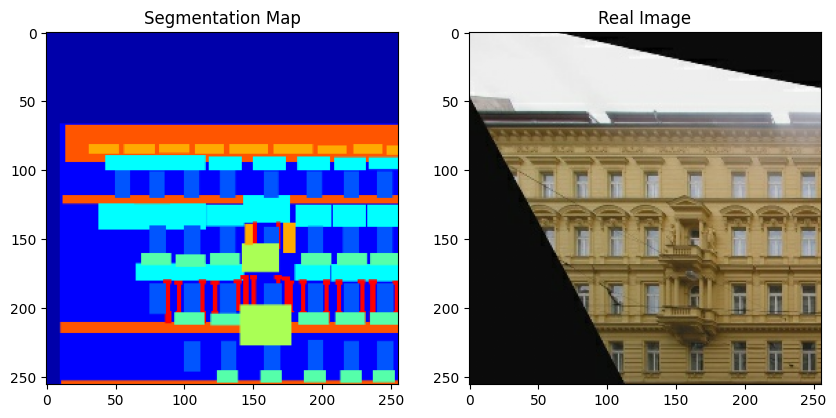

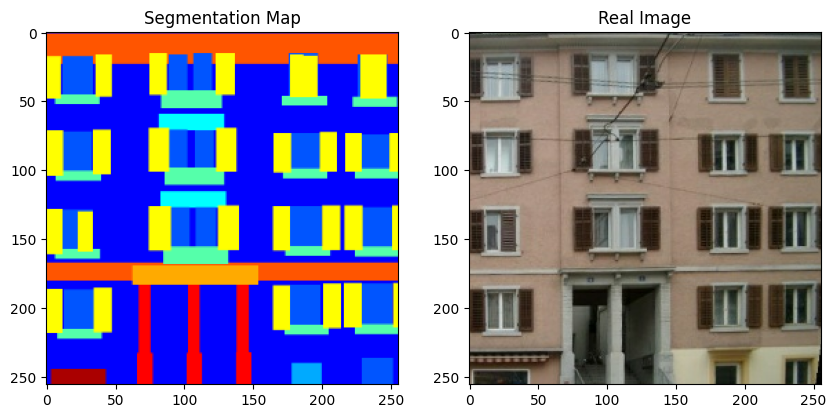

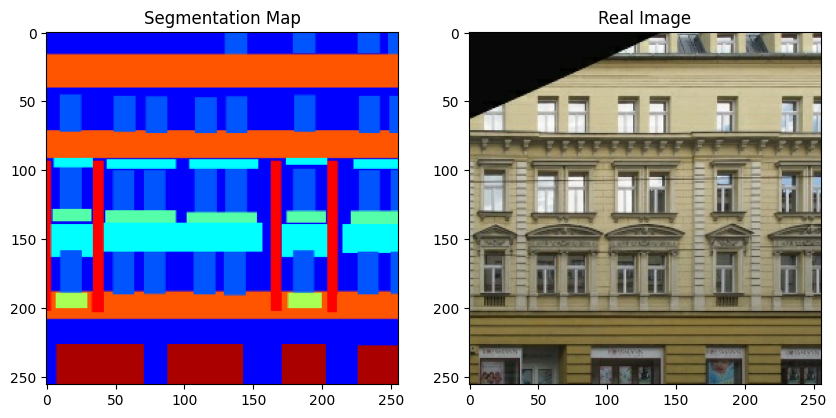

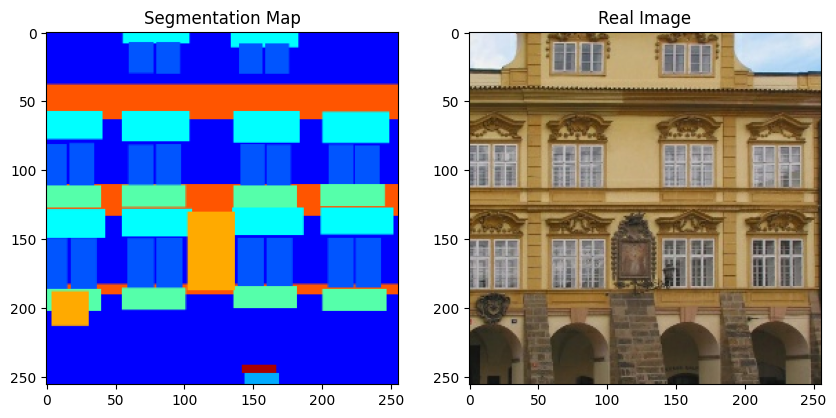

In [ ]:
sample_train_batch = next(iter(train_dataset))
print(f"Segmentation map batch shape: {sample_train_batch[0].shape}.")
print(f"Image batch shape: {sample_train_batch[1].shape}.")
print(f"One-hot encoded label map shape: {sample_train_batch[2].shape}.")

# Plot a view samples from the training set.
for segmentation_map, real_image in zip(sample_train_batch[0], sample_train_batch[1]):
    fig = plt.figure(figsize=(10, 10))
    fig.add_subplot(1, 2, 1).set_title("Segmentation Map")
    plt.imshow((segmentation_map + 1) / 2)
    fig.add_subplot(1, 2, 2).set_title("Real Image")
    plt.imshow((real_image + 1) / 2)
    plt.show()

Note that in the rest of this example, we use a couple of figures from the
[original GauGAN paper](https://arxiv.org/abs/1903.07291) for convenience.



## Custom layers

In the following section, we implement the following layers:

* SPADE
* Residual block including SPADE
* Gaussian sampler



### Some more notes on SPADE

![](https://i.imgur.com/DgMWrrs.png)

**SPatially-Adaptive (DE) normalization** or **SPADE** is a simple but effective layer
for synthesizing photorealistic images given an input semantic layout. Previous methods
for conditional image generation from semantic input such as
Pix2Pix ([Isola et al.](https://arxiv.org/abs/1611.07004))
or Pix2PixHD ([Wang et al.](https://arxiv.org/abs/1711.11585))
directly feed the semantic layout as input to the deep network, which is then processed
through stacks of convolution, normalization, and nonlinearity layers. This is often
suboptimal as the normalization layers have a tendency to wash away semantic information.

In SPADE, the segmentation mask is first projected onto an embedding space, and then
convolved to produce the modulation parameters `γ` and `β`. Unlike prior conditional
normalization methods, `γ` and `β` are not vectors, but tensors with spatial dimensions.
The produced `γ` and `β` are multiplied and added to the normalized activation
element-wise. As the modulation parameters are adaptive to the input segmentation mask,
SPADE is better suited for semantic image synthesis.

In [ ]:
class SPADE(layers.Layer):
    def __init__(self, filters, epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon
        self.conv = layers.Conv2D(128, 3, padding="same", activation="relu")
        self.conv_gamma = layers.Conv2D(filters, 3, padding="same")
        self.conv_beta = layers.Conv2D(filters, 3, padding="same")

    def build(self, input_shape):
        self.resize_shape = input_shape[1:3]

    def call(self, input_tensor, raw_mask):
        mask = tf.image.resize(raw_mask, self.resize_shape, method="nearest")
        x = self.conv(mask)
        gamma = self.conv_gamma(x)
        beta = self.conv_beta(x)
        mean, var = tf.nn.moments(input_tensor, axes=(0, 1, 2), keepdims=True)
        std = tf.sqrt(var + self.epsilon)
        normalized = (input_tensor - mean) / std
        output = gamma * normalized + beta
        return output


class ResBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters

    def build(self, input_shape):
        input_filter = input_shape[-1]
        self.spade_1 = SPADE(input_filter)
        self.spade_2 = SPADE(self.filters)
        self.conv_1 = layers.Conv2D(self.filters, 3, padding="same")
        self.conv_2 = layers.Conv2D(self.filters, 3, padding="same")
        self.learned_skip = False

        if self.filters != input_filter:
            self.learned_skip = True
            self.spade_3 = SPADE(input_filter)
            self.conv_3 = layers.Conv2D(self.filters, 3, padding="same")

    def call(self, input_tensor, mask):
        x = self.spade_1(input_tensor, mask)
        x = self.conv_1(tf.nn.leaky_relu(x, 0.2))
        x = self.spade_2(x, mask)
        x = self.conv_2(tf.nn.leaky_relu(x, 0.2))
        skip = (
            self.conv_3(tf.nn.leaky_relu(self.spade_3(input_tensor, mask), 0.2))
            if self.learned_skip
            else input_tensor
        )
        output = skip + x
        return output


class GaussianSampler(layers.Layer):
    def __init__(self, batch_size, latent_dim, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size
        self.latent_dim = latent_dim

    def call(self, inputs):
        means, variance = inputs
        epsilon = tf.random.normal(
            shape=(self.batch_size, self.latent_dim), mean=0.0, stddev=1.0
        )
        samples = means + tf.exp(0.5 * variance) * epsilon
        return samples

Next, we implement the downsampling block for the encoder.

In [ ]:
def downsample(channels, kernels, strides=2, apply_norm=True, apply_activation=True, apply_dropout=False):
    block = keras.Sequential()
    block.add(
        layers.Conv2D(
            channels,
            kernels,
            strides=strides,
            padding="same",
            use_bias=False,
            kernel_initializer=keras.initializers.GlorotNormal(),
        )
    )
    if apply_norm:
        block.add(tfa.layers.InstanceNormalization())
    if apply_activation:
        block.add(layers.LeakyReLU(0.2))
    if apply_dropout:
        block.add(layers.Dropout(0.5))
    return block

The GauGAN encoder consists of a few downsampling blocks. It outputs the mean and
variance of a distribution.

![](https://i.imgur.com/JgAv1EW.png)

In [ ]:
def build_encoder(image_shape, encoder_downsample_factor=64, latent_dim=256):
    input_image = keras.Input(shape=image_shape)
    x = downsample(encoder_downsample_factor, 3, apply_norm=False)(input_image)
    x = downsample(2 * encoder_downsample_factor, 3)(x)
    x = downsample(4 * encoder_downsample_factor, 3)(x)
    x = downsample(8 * encoder_downsample_factor, 3)(x)
    x = downsample(8 * encoder_downsample_factor, 3)(x)
    x = layers.Flatten()(x)
    mean = layers.Dense(latent_dim, name="mean")(x)
    variance = layers.Dense(latent_dim, name="variance")(x)
    return keras.Model(input_image, [mean, variance], name="encoder")

Next, we implement the generator, which consists of the modified residual blocks and
upsampling blocks. It takes latent vectors and one-hot encoded segmentation labels, and
produces new images.

![](https://i.imgur.com/9iP1TsB.png)

With SPADE, there is no need to feed the segmentation map to the first layer of the
generator, since the latent inputs have enough structural information about the style we
want the generator to emulate. We also discard the encoder part of the generator, which is
commonly used in prior architectures. This results in a more lightweight
generator network, which can also take a random vector as input, enabling a simple and
natural path to multi-modal synthesis.

In [ ]:
def build_generator(mask_shape, latent_dim=256):
    latent = keras.Input(shape=(latent_dim))
    mask = keras.Input(shape=mask_shape)
    x = layers.Dense(16384)(latent)
    x = layers.Reshape((4, 4, 1024))(x)
    x = ResBlock(filters=1024)(x, mask)
    x = layers.UpSampling2D((2, 2))(x)
    x = ResBlock(filters=1024)(x, mask)
    x = layers.UpSampling2D((2, 2))(x)
    x = ResBlock(filters=1024)(x, mask)
    x = layers.UpSampling2D((2, 2))(x)
    x = ResBlock(filters=512)(x, mask)
    x = layers.UpSampling2D((2, 2))(x)
    x = ResBlock(filters=256)(x, mask)
    x = layers.UpSampling2D((2, 2))(x)
    x = ResBlock(filters=128)(x, mask)
    x = layers.UpSampling2D((2, 2))(x)
    x = tf.nn.leaky_relu(x, 0.2)
    output_image = tf.nn.tanh(layers.Conv2D(3, 4, padding="same")(x))
    return keras.Model([latent, mask], output_image, name="generator")

The discriminator takes a segmentation map and an image and concatenates them. It
then predicts if patches of the concatenated image are real or fake.

![](https://i.imgur.com/rn71PlM.png)

In [ ]:
def build_discriminator(image_shape, downsample_factor=64):
    input_image_A = keras.Input(shape=image_shape, name="discriminator_image_A")
    input_image_B = keras.Input(shape=image_shape, name="discriminator_image_B")
    x = layers.Concatenate()([input_image_A, input_image_B])
    x1 = downsample(downsample_factor, 4, apply_norm=False)(x)
    x2 = downsample(2 * downsample_factor, 4)(x1)
    x3 = downsample(4 * downsample_factor, 4)(x2)
    x4 = downsample(8 * downsample_factor, 4, strides=1)(x3)
    x5 = layers.Conv2D(1, 4)(x4)
    outputs = [x1, x2, x3, x4, x5]
    return keras.Model([input_image_A, input_image_B], outputs)

## Loss functions

GauGAN uses the following loss functions:

* Generator:

    * Expectation over the discriminator predictions.
    * [KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)
    for learning the mean and variance predicted by the encoder.
    * Minimization between the discriminator predictions on original and generated
    images to align the feature space of the generator.
    * [Perceptual loss](https://arxiv.org/abs/1603.08155) for encouraging the generated
    images to have perceptual quality.

* Discriminator:

    * [Hinge loss](https://en.wikipedia.org/wiki/Hinge_loss).

In [ ]:
def generator_loss(y):
    return -tf.reduce_mean(y)


def kl_divergence_loss(mean, variance):
    return -0.5 * tf.reduce_sum(1 + variance - tf.square(mean) - tf.exp(variance))


class FeatureMatchingLoss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.mae = keras.losses.MeanAbsoluteError()

    def call(self, y_true, y_pred):
        loss = 0
        for i in range(len(y_true) - 1):
            loss += self.mae(y_true[i], y_pred[i])
        return loss


class VGGFeatureMatchingLoss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.encoder_layers = [
            "block1_conv1",
            "block2_conv1",
            "block3_conv1",
            "block4_conv1",
            "block5_conv1",
        ]
        self.weights = [1.0 / 32, 1.0 / 16, 1.0 / 8, 1.0 / 4, 1.0]
        vgg = keras.applications.VGG19(include_top=False, weights="imagenet")
        layer_outputs = [vgg.get_layer(x).output for x in self.encoder_layers]
        self.vgg_model = keras.Model(vgg.input, layer_outputs, name="VGG")
        self.mae = keras.losses.MeanAbsoluteError()

    def call(self, y_true, y_pred):
        y_true = keras.applications.vgg19.preprocess_input(127.5 * (y_true + 1))
        y_pred = keras.applications.vgg19.preprocess_input(127.5 * (y_pred + 1))
        real_features = self.vgg_model(y_true)
        fake_features = self.vgg_model(y_pred)
        loss = 0
        for i in range(len(real_features)):
            loss += self.weights[i] * self.mae(real_features[i], fake_features[i])
        return loss


class DiscriminatorLoss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hinge_loss = keras.losses.Hinge()

    def call(self, y, is_real):
        label = 1.0 if is_real else -1.0
        return self.hinge_loss(label, y)

## GAN monitor callback

Next, we implement a callback to monitor the GauGAN results while it is training.

In [ ]:
class GanMonitor(keras.callbacks.Callback):
    def __init__(self, val_dataset, n_samples, epoch_interval=5):
        self.val_images = next(iter(val_dataset))
        self.n_samples = n_samples
        self.epoch_interval = epoch_interval

    def infer(self):
        latent_vector = tf.random.normal(
            shape=(self.model.batch_size, self.model.latent_dim), mean=0.0, stddev=2.0
        )
        return self.model.predict([latent_vector, self.val_images[2]])

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.epoch_interval == 0:
            generated_images = self.infer()
            for _ in range(self.n_samples):
                grid_row = min(generated_images.shape[0], 3)
                f, axarr = plt.subplots(grid_row, 3, figsize=(18, grid_row * 6))
                for row in range(grid_row):
                    ax = axarr if grid_row == 1 else axarr[row]
                    ax[0].imshow((self.val_images[0][row] + 1) / 2)
                    ax[0].axis("off")
                    ax[0].set_title("Mask", fontsize=20)
                    ax[1].imshow((self.val_images[1][row] + 1) / 2)
                    ax[1].axis("off")
                    ax[1].set_title("Ground Truth", fontsize=20)
                    ax[2].imshow((generated_images[row] + 1) / 2)
                    ax[2].axis("off")
                    ax[2].set_title("Generated", fontsize=20)
                plt.show()

## Subclassed GauGAN model

Finally, we put everything together inside a subclassed model (from `tf.keras.Model`)
overriding its `train_step()` method.

In [ ]:
class GauGAN(keras.Model):
    def __init__(
        self,
        image_size,
        num_classes,
        batch_size,
        latent_dim,
        feature_loss_coeff=10,
        vgg_feature_loss_coeff=0.1,
        kl_divergence_loss_coeff=0.1,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.image_size = image_size
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.image_shape = (image_size, image_size, 3)
        self.mask_shape = (image_size, image_size, num_classes)
        self.feature_loss_coeff = feature_loss_coeff
        self.vgg_feature_loss_coeff = vgg_feature_loss_coeff
        self.kl_divergence_loss_coeff = kl_divergence_loss_coeff

        self.discriminator = build_discriminator(self.image_shape)
        self.generator = build_generator(self.mask_shape)
        self.encoder = build_encoder(self.image_shape)
        self.sampler = GaussianSampler(batch_size, latent_dim)
        self.patch_size, self.combined_model = self.build_combined_generator()

        self.disc_loss_tracker = tf.keras.metrics.Mean(name="disc_loss")
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="gen_loss")
        self.feat_loss_tracker = tf.keras.metrics.Mean(name="feat_loss")
        self.vgg_loss_tracker = tf.keras.metrics.Mean(name="vgg_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.disc_loss_tracker,
            self.gen_loss_tracker,
            self.feat_loss_tracker,
            self.vgg_loss_tracker,
            self.kl_loss_tracker,
        ]

    def build_combined_generator(self):
        # This method builds a model that takes as inputs the following:
        # latent vector, one-hot encoded segmentation label map, and
        # a segmentation map. It then (i) generates an image with the generator,
        # (ii) passes the generated images and segmentation map to the discriminator.
        # Finally, the model produces the following outputs: (a) discriminator outputs,
        # (b) generated image.
        # We will be using this model to simplify the implementation.
        self.discriminator.trainable = False
        mask_input = keras.Input(shape=self.mask_shape, name="mask")
        image_input = keras.Input(shape=self.image_shape, name="image")
        latent_input = keras.Input(shape=(self.latent_dim), name="latent")
        generated_image = self.generator([latent_input, mask_input])
        discriminator_output = self.discriminator([image_input, generated_image])
        patch_size = discriminator_output[-1].shape[1]
        combined_model = keras.Model(
            [latent_input, mask_input, image_input],
            [discriminator_output, generated_image],
        )
        return patch_size, combined_model

    def compile(self, gen_lr=1e-4, disc_lr=4e-4, **kwargs):
        super().compile(**kwargs)
        self.generator_optimizer = keras.optimizers.Adam(
            gen_lr, beta_1=0.0, beta_2=0.999
        )
        self.discriminator_optimizer = keras.optimizers.Adam(
            disc_lr, beta_1=0.0, beta_2=0.999
        )
        self.discriminator_loss = DiscriminatorLoss()
        self.feature_matching_loss = FeatureMatchingLoss()
        self.vgg_loss = VGGFeatureMatchingLoss()

    def train_discriminator(self, latent_vector, segmentation_map, real_image, labels):
        fake_images = self.generator([latent_vector, labels])
        with tf.GradientTape() as gradient_tape:
            pred_fake = self.discriminator([segmentation_map, fake_images])[-1]
            pred_real = self.discriminator([segmentation_map, real_image])[-1]
            loss_fake = self.discriminator_loss(pred_fake, False)
            loss_real = self.discriminator_loss(pred_real, True)
            total_loss = 0.5 * (loss_fake + loss_real)

        self.discriminator.trainable = True
        gradients = gradient_tape.gradient(
            total_loss, self.discriminator.trainable_variables
        )
        self.discriminator_optimizer.apply_gradients(
            zip(gradients, self.discriminator.trainable_variables)
        )
        return total_loss

    def train_generator(
        self, latent_vector, segmentation_map, labels, image, mean, variance
    ):
        # Generator learns through the signal provided by the discriminator. During
        # backpropagation, we only update the generator parameters.
        self.discriminator.trainable = False
        with tf.GradientTape() as tape:
            real_d_output = self.discriminator([segmentation_map, image])
            fake_d_output, fake_image = self.combined_model(
                [latent_vector, labels, segmentation_map]
            )
            pred = fake_d_output[-1]

            # Compute generator losses.
            g_loss = generator_loss(pred)
            kl_loss = self.kl_divergence_loss_coeff * kl_divergence_loss(mean, variance)
            vgg_loss = self.vgg_feature_loss_coeff * self.vgg_loss(image, fake_image)
            feature_loss = self.feature_loss_coeff * self.feature_matching_loss(
                real_d_output, fake_d_output
            )
            total_loss = g_loss + kl_loss + vgg_loss + feature_loss

        all_trainable_variables = (
            self.combined_model.trainable_variables + self.encoder.trainable_variables
        )

        gradients = tape.gradient(total_loss, all_trainable_variables)
        self.generator_optimizer.apply_gradients(
            zip(gradients, all_trainable_variables)
        )
        return total_loss, feature_loss, vgg_loss, kl_loss

    def train_step(self, data):
        segmentation_map, image, labels = data
        mean, variance = self.encoder(image)
        latent_vector = self.sampler([mean, variance])
        discriminator_loss = self.train_discriminator(
            latent_vector, segmentation_map, image, labels
        )
        (generator_loss, feature_loss, vgg_loss, kl_loss) = self.train_generator(
            latent_vector, segmentation_map, labels, image, mean, variance
        )

        # Report progress.
        self.disc_loss_tracker.update_state(discriminator_loss)
        self.gen_loss_tracker.update_state(generator_loss)
        self.feat_loss_tracker.update_state(feature_loss)
        self.vgg_loss_tracker.update_state(vgg_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        results = {m.name: m.result() for m in self.metrics}
        return results

    def test_step(self, data):
        segmentation_map, image, labels = data
        # Obtain the learned moments of the real image distribution.
        mean, variance = self.encoder(image)

        # Sample a latent from the distribution defined by the learned moments.
        latent_vector = self.sampler([mean, variance])

        # Generate the fake images.
        fake_images = self.generator([latent_vector, labels])

        # Calculate the losses.
        pred_fake = self.discriminator([segmentation_map, fake_images])[-1]
        pred_real = self.discriminator([segmentation_map, image])[-1]
        loss_fake = self.discriminator_loss(pred_fake, False)
        loss_real = self.discriminator_loss(pred_real, True)
        total_discriminator_loss = 0.5 * (loss_fake + loss_real)
        real_d_output = self.discriminator([segmentation_map, image])
        fake_d_output, fake_image = self.combined_model(
            [latent_vector, labels, segmentation_map]
        )
        pred = fake_d_output[-1]
        g_loss = generator_loss(pred)
        kl_loss = self.kl_divergence_loss_coeff * kl_divergence_loss(mean, variance)
        vgg_loss = self.vgg_feature_loss_coeff * self.vgg_loss(image, fake_image)
        feature_loss = self.feature_loss_coeff * self.feature_matching_loss(
            real_d_output, fake_d_output
        )
        total_generator_loss = g_loss + kl_loss + vgg_loss + feature_loss

        # Report progress.
        self.disc_loss_tracker.update_state(total_discriminator_loss)
        self.gen_loss_tracker.update_state(total_generator_loss)
        self.feat_loss_tracker.update_state(feature_loss)
        self.vgg_loss_tracker.update_state(vgg_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        results = {m.name: m.result() for m in self.metrics}
        return results

    def call(self, inputs):
        latent_vectors, labels = inputs
        return self.generator([latent_vectors, labels])

## GauGAN training

In [ ]:
gaugan = GauGAN(IMG_HEIGHT, NUM_CLASSES, BATCH_SIZE, latent_dim=256)
gaugan.compile()
history = gaugan.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    callbacks=[GanMonitor(val_dataset, BATCH_SIZE)],
)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("disc_loss")
plot_history("gen_loss")
plot_history("feat_loss")
plot_history("vgg_loss")
plot_history("kl_loss")

## Inference

In [ ]:
val_iterator = iter(val_dataset)

for _ in range(5):
    val_images = next(val_iterator)
    # Sample latent from a normal distribution.
    latent_vector = tf.random.normal(
        shape=(gaugan.batch_size, gaugan.latent_dim), mean=0.0, stddev=2.0
    )
    # Generate fake images.
    fake_images = gaugan.predict([latent_vector, val_images[2]])

    real_images = val_images
    grid_row = min(fake_images.shape[0], 3)
    grid_col = 3
    f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col * 6, grid_row * 6))
    for row in range(grid_row):
        ax = axarr if grid_row == 1 else axarr[row]
        ax[0].imshow((real_images[0][row] + 1) / 2)
        ax[0].axis("off")
        ax[0].set_title("Mask", fontsize=20)
        ax[1].imshow((real_images[1][row] + 1) / 2)
        ax[1].axis("off")
        ax[1].set_title("Ground Truth", fontsize=20)
        ax[2].imshow((fake_images[row] + 1) / 2)
        ax[2].axis("off")
        ax[2].set_title("Generated", fontsize=20)
    plt.show()

## Final words

* The dataset we used in this example is a small one. For obtaining even better results
we recommend to use a bigger dataset. GauGAN results were demonstrated with the
[COCO-Stuff](https://github.com/nightrome/cocostuff) and
[CityScapes](https://www.cityscapes-dataset.com/) datasets.
* This example was inspired the Chapter 6 of
[Hands-On Image Generation with TensorFlow](https://www.packtpub.com/product/hands-on-image-generation-with-tensorflow/9781838826789)
by [Soon-Yau Cheong](https://www.linkedin.com/in/soonyau/) and
[Implementing SPADE using fastai](https://towardsdatascience.com/implementing-spade-using-fastai-6ad86b94030a) by
[Divyansh Jha](https://medium.com/@divyanshj.16).
* If you found this example interesting and exciting, you might want to check out
[our repository](https://github.com/soumik12345/tf2_gans) which we are
currently building. It will include reimplementations of popular GANs and pretrained
models. Our focus will be on readability and making the code as accessible as possible.
Our plain is to first train our implementation of GauGAN (following the code of
this example) on a bigger dataset and then make the repository public. We welcome
contributions!
* Recently GauGAN2 was also released. You can check it out
[here](https://blogs.nvidia.com/blog/2021/11/22/gaugan2-ai-art-demo/).